In [1]:
import warnings
warnings.filterwarnings("ignore")

from network import *
import numpy as np
import math, pdb
from tqdm import trange, tqdm
from sklearn import model_selection
import sklearn
from PIL import Image
import glob
import os
import scipy.misc
import sys
import pickle
import random
import matplotlib.pyplot as plt
import pdb


import tensorflow as tf
from tensorflow.contrib import layers
# %matplotlib inline
%config InlineBackend.figure_format='retina'




In [2]:
# for shallow
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1.


# def prepare_image_EEG_nr(epoch_t, epoch_s, p3_win):
#     img_dir =  '/home/zhengwei/notebooks/dataset/JANUS_imgs'
#     # load EEG and corresponding images
#     # for standard
#     epoch_array_s = np.stack(epoch_s.values())[:,0,:]
#     p3_s = epoch_array_s[:, p3_win[0]:p3_win[1]].max(axis=1).mean()
#     im_ndarrays = []
#     epoch_array_t = []
#     nr = []
#     label = [] # 1: DCGAN, 2: BEGAN, 3: PROGAN, 4: RFACE
#     for key in epoch_t.keys():
#         nr.append(epoch_t[key][0,p3_win[0]:p3_win[1]].max() - p3_s )
#         epoch_array_t.append(epoch_t[key][0])
#         im = Image.open(os.path.join(img_dir, key))
#         im_ndarray = np.array(im)
#         im_ndarrays.append(im_ndarray)
#         if 'T_DCGAN' in key:
#             label.append(1)
#         elif 'T_BEGAN' in key:
#             label.append(2)
#         elif 'T_PROGAN' in key:
#             label.append(3)
#         elif 'T_RFACE' in key:
#             label.append(4)

#     nr = np.stack(nr).reshape(-1, 1)
#     im_ndarrays = np.stack(im_ndarrays)
#     epoch_array_t = np.stack(epoch_array_t)
#     return epoch_array_t, epoch_array_s, im_ndarrays, nr, np.stack(label).reshape(-1,1)


# nr_pred, eeg_pred, W_eeg, W_nr, = shallow_networks()
# print(eeg_pred)
# sess = tf.InteractiveSession()

In [3]:
# for mobilenet v2

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1.

# def prepare_image_EEG_nr(epoch_t, epoch_s, p3_win):
#     img_dir =  '/home/zhengwei/notebooks/dataset/JANUS_imgs'
#     # load EEG and corresponding images
#     # for standard
#     epoch_array_s = np.stack(epoch_s.values())[:,0,:]
#     p3_s = epoch_array_s[:, p3_win[0]:p3_win[1]].max(axis=1).mean()
#     im_ndarrays = []
#     epoch_array_t = []
#     nr = []
#     label = [] # 1: DCGAN, 2: BEGAN, 3: PROGAN, 4: RFACE
#     for key in epoch_t.keys():
#         nr.append(epoch_t[key][0,p3_win[0]:p3_win[1]].max() - p3_s )
#         epoch_array_t.append(epoch_t[key][0])
#         im = Image.open(os.path.join(img_dir, key))
#         im_ndarray = np.array(im.resize((224,224)))
#         im_ndarrays.append(im_ndarray)
#         if 'T_DCGAN' in key:
#             label.append(1)
#         elif 'T_BEGAN' in key:
#             label.append(2)
#         elif 'T_PROGAN' in key:
#             label.append(3)
#         elif 'T_RFACE' in key:
#             label.append(4)

#     nr = np.stack(nr).reshape(-1, 1)
#     im_ndarrays = np.stack(im_ndarrays)
#     epoch_array_t = np.stack(epoch_array_t)
#     return epoch_array_t, epoch_array_s, im_ndarrays, nr, np.stack(label).reshape(-1,1)
# nr_pred, eeg_pred, W_eeg, W_nr, = mobilenet_v2(config)
# print(eeg_pred)
# sess = tf.InteractiveSession()

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.




def prepare_image_EEG_nr(epoch_t, epoch_s, p3_win):
    img_dir =  '/home/zhengwei/notebooks/dataset/JANUS_imgs'
    # load EEG and corresponding images
    # for standard
    epoch_array_s = np.stack(epoch_s.values())[:,0,:]
    p3_s = epoch_array_s[:, p3_win[0]:p3_win[1]].max(axis=1).mean()
    im_ndarrays = []
    epoch_array_t = []
    nr = []
    label = [] # 1: DCGAN, 2: BEGAN, 3: PROGAN, 4: RFACE
    for key in epoch_t.keys():
        nr.append(epoch_t[key][0,p3_win[0]:p3_win[1]].max() - p3_s )
        epoch_array_t.append(epoch_t[key][0])
        im = Image.open(os.path.join(img_dir, key))
        im_ndarray = np.array(im)
        im_ndarrays.append(im_ndarray)
        if 'T_DCGAN' in key:
            label.append(1)
        elif 'T_BEGAN' in key:
            label.append(2)
        elif 'T_PROGAN' in key:
            label.append(3)
        elif 'T_RFACE' in key:
            label.append(4)

    nr = np.stack(nr).reshape(-1, 1)
    im_ndarrays = np.stack(im_ndarrays)
    epoch_array_t = np.stack(epoch_array_t)
    return epoch_array_t, epoch_array_s, im_ndarrays, nr, np.stack(label).reshape(-1,1)
nr_pred, eeg_pred, W_eeg, W_nr, = inception_v3(config)
print(eeg_pred)
sess = tf.InteractiveSession()

Instructions for updating:
Use tf.gfile.GFile.
Inception graph loaded!
Tensor("MatMul_2:0", shape=(?, 50), dtype=float32)


In [3]:
# specialized for training
y_nr_tensor = tf.placeholder(tf.float32, [None, 1], name='y_nr_tensor')
nr_reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)[-1::]
reg_constant_nr = 0.
loss_nr = tf.reduce_mean(tf.square(nr_pred - y_nr_tensor)) + reg_constant_nr * sum(nr_reg_losses)
# loss_nr = tf.reduce_mean(tf.square(nr_pred - y_nr_tensor))
train_vars_nr = W_eeg + W_nr
optimizer_nr = tf.train.AdamOptimizer(.001).minimize(loss_nr, var_list=train_vars_nr)
# optimizer_nr_eeg = tf.train.AdamOptimizer(.0001).minimize(loss_nr, var_list=train_vars_eeg)
# train_op = tf.group(optimizer_nr, optimizer_nr_eeg)

In [4]:
def cal_p3_amp(epoch_t, epoch_s):
    p3_t = np.max(epoch_t, axis=1)
    p3_s = np.max(epoch_s, axis=1).mean()
    return p3_t - p3_s

def compute_nr(epoch_t, epoch_s):
    nr = cal_p3_amp(epoch_t, epoch_s)
    return nr.mean()



def compute_nr_mean(epoch_t, epoch_s):
    source = epoch_t.mean(axis=0) - epoch_s.mean(axis=0)
    return source.max()


# normalize the input image
def preprocess_input(X):
#     mean_ = [0.485, 0.456, 0.406]
#     std_ = [0.229, 0.224, 0.225]
    X_norm = []
    for x in X:
        x = np.divide(x, 255.0)
        x = np.subtract(x, .5)
        x = np.multiply(x, 2.0)
        X_norm.append(x)
#         x =  np.divide(x, 128.0)
#         x = np.subtract(x, 1.)
#         X_norm.append(x)

    X_norm = np.stack(X_norm)
    return X_norm

def prepare_p3_source(p3_dcgan, p3_began, p3_progan, p3_rface, label):
    p3_source_train = []
    for label_ in label:
        if label_ == 1:
            p3_source_train.append(p3_dcgan[0])
        elif label_ == 2:
            p3_source_train.append(p3_began[0])
        elif label_ == 3:
            p3_source_train.append(p3_progan[0])
        elif label_ == 4:
            p3_source_train.append(p3_rface[0])
    p3_source_train = np.stack(p3_source_train)
    return p3_source_train



EEG_path = '/home/zhengwei/notebooks/GAN/evaluate_gan/dataset/image_EEG_data'
SUB_ID = ['janus16thMay', 'janus20thMay', 'janus29thMay', 'janus17thJuly', 'janus19thJuly', 'janus9thAug', \
          'janus14thAug', 'janus15thAug', 'janus20thAug', 'janus6thNov', 'janus15thNov', 'janus19thNov']
T_IDs = ['DCGAN', 'BEGAN', 'PROGAN', 'RFACE']
epoch_subs_ids = ['sub{}'.format(i) for i in range(1,13)]
opt_ind = [102, 129, 125, 132, 100, 104, 116, 100, 107, 111, 110, 100]


# epoch_subs_ids = ['sub2']

epoch_array_t_subs = np.empty([0, 250])
epoch_array_s_subs = np.empty([0, 250])
im_ndarrays_subs = np.empty([0, 128, 128, 3]) # for inception and shallow
# im_ndarrays_subs = np.empty([0, 224, 224, 3]) # for mobilenet



nr_subs = np.empty([0, 1])
label_subs = np.empty([0, 1])
p3_baseline_subs = []
p3_dcgan_subs = np.empty([0, 250])
p3_began_subs = np.empty([0, 250])
p3_progan_subs = np.empty([0, 250])
p3_rface_subs = np.empty([0, 250])
for i, epoch_sub_id in enumerate(epoch_subs_ids):
    p3_win = [int(opt_ind[i]-25), int(opt_ind[i]+25)]
    with open('{}/{}_S.pickle'.format(EEG_path, epoch_sub_id), 'rb') as handle:
        epoch_s = pickle.load(handle, encoding='latin1')

    with open('{}/{}_T.pickle'.format(EEG_path, epoch_sub_id), 'rb') as handle:
        epoch_t = pickle.load(handle, encoding='latin1')

    epoch_array_t, epoch_array_s, im_ndarrays, nr, label = prepare_image_EEG_nr(epoch_t, epoch_s, p3_win)   
    im_ndarrays = preprocess_input(im_ndarrays)
    p3_baseline = np.max(epoch_array_s[:, p3_win[0]:p3_win[1]], axis = 1).mean(axis=0)
    p3_dcgan = np.mean(epoch_array_t[label[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_began = np.mean(epoch_array_t[label[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_progan = np.mean(epoch_array_t[label[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)
    p3_rface = np.mean(epoch_array_t[label[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s, axis=0, keepdims=True)

    
    epoch_array_t_subs = np.r_[epoch_array_t_subs, epoch_array_t]
    epoch_array_s_subs = np.r_[epoch_array_s_subs, epoch_array_s]
    im_ndarrays_subs = np.r_[im_ndarrays_subs, im_ndarrays]
    nr_subs = np.r_[nr_subs, nr]
    label_subs = np.r_[label_subs, label]
    p3_baseline_subs.append(p3_baseline)
    p3_dcgan_subs = np.r_[p3_dcgan_subs, p3_dcgan]
    p3_began_subs = np.r_[p3_began_subs, p3_began]
    p3_progan_subs = np.r_[p3_progan_subs, p3_progan]
    p3_rface_subs = np.r_[p3_rface_subs, p3_rface]  
    

    # compute nr for different cats
    print(epoch_sub_id)
    for cat in T_IDs:
        epoch_t_ = []
        for key in epoch_t.keys():
            if cat in key:
                epoch_t_.append(epoch_t[key][0])
        epoch_t_ = np.stack(epoch_t_)
        print('{}: {}'.format(cat, compute_nr(epoch_t_[:, p3_win[0]:p3_win[1]], epoch_array_s[:, p3_win[0]:p3_win[1]]) ))
    
    print('\n')
p3_baseline_subs = np.stack(p3_baseline_subs)

Y = np.c_[epoch_array_t_subs, nr_subs, label_subs]    
# if sub_id == 'janus16thMay':
#     batch_size = 42
# else:
#     batch_size = 48
batch_size = 128    
print('available EEG trials', epoch_array_t_subs.shape[0])

sub1
DCGAN: 0.577384413073291
BEGAN: 0.6675170388885293
PROGAN: 0.6845382677475359
RFACE: 0.6412800022706485


sub2
DCGAN: 0.6128322979230609
BEGAN: 0.768541488954685
PROGAN: 0.9389079182847797
RFACE: 0.8197694486654774


sub3
DCGAN: 0.44568696524530876
BEGAN: 0.6304410627070833
PROGAN: 0.6890422608636503
RFACE: 0.5913261807116696


sub4
DCGAN: 0.4316418356395805
BEGAN: 0.5761840142757186
PROGAN: 0.9744673865238189
RFACE: 0.9303083274620967


sub5
DCGAN: 0.6576208247846607
BEGAN: 0.9067623743161052
PROGAN: 0.9383027368364043
RFACE: 0.7217306547089111


sub6
DCGAN: 0.6025220957777832
BEGAN: 0.7739764533867114
PROGAN: 0.9646343716735595
RFACE: 0.8114619131384391


sub7
DCGAN: 0.46197308762318373
BEGAN: 0.5836175622940424
PROGAN: 0.8564983792866895
RFACE: 0.8116791615343842


sub8
DCGAN: 0.8239750255001284
BEGAN: 0.8379381221491335
PROGAN: 0.8817393178749626
RFACE: 0.7891165731419673


sub9
DCGAN: 0.6822904076715401
BEGAN: 0.7226243507205125
PROGAN: 0.9113484683756407
RFACE: 0.90821099492

In [5]:
# feed single trial P300 amplitude to loss 2
loss_nr_test_loop = []
nr_loss_cat_test_loop = []
nr_loss_cat_true_loop = []
nr_loss_cat_test_loop_ = []
nr_loss_single = []



# shallow
epochs = 10
batch_size = 128 

x_train, x_test, y_train, y_test = model_selection.train_test_split(im_ndarrays_subs, Y, 
                                                                    test_size=0.3, random_state=0)
label_train = y_train[:, 251:252]
label_test = y_test[:, 251:252]
nr_train = y_train[:, 250:251]
nr_test = y_test[:, 250:251]
eeg_train = y_train[:, 0:250]
eeg_test = y_test[:, 0:250]

batch_idx = int(nr_train.shape[0]/batch_size)



p3_dcgan_train = np.mean(eeg_train[label_train[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_began_train = np.mean(eeg_train[label_train[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_progan_train = np.mean(eeg_train[label_train[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_rface_train = np.mean(eeg_train[label_train[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)

p3_dcgan_test = np.mean(eeg_test[label_test[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_began_test = np.mean(eeg_test[label_test[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_progan_test = np.mean(eeg_test[label_test[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
p3_rface_test = np.mean(eeg_test[label_test[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)


p3_source_train = prepare_p3_source(p3_dcgan_train, p3_began_train, p3_progan_train, p3_rface_train, label_train)
p3_source_test = prepare_p3_source(p3_dcgan_test, p3_began_test, p3_progan_test, p3_rface_test, label_test)


init = tf.global_variables_initializer()
sess.run(init)    


loss_track = []
for epoch in trange(epochs):
    for idx in range(batch_idx):
        x_batch = x_train[idx*batch_size:(idx+1)*batch_size]
#         nr_batch = nr_mean_train[label_train[:,0]!=4][idx*batch_size:(idx+1)*batch_size]
        nr_batch = nr_train[idx*batch_size:(idx+1)*batch_size]
#         nr_batch = p3_source_train[idx*batch_size:(idx+1)*batch_size,100:150].max(axis=1, keepdims=True) # use the averaged P300 amplitude
        
        # inception uses ExpandDims:0 others use input:0
        _, loss_ = sess.run([optimizer_nr, loss_nr], 
                        feed_dict={'ExpandDims:0': x_batch, 
                                  y_nr_tensor: nr_batch})
#         _, loss_ = sess.run([optimizer_nr, loss_nr], 
#                             feed_dict={'input:0': x_batch, 
#                                       y_nr_tensor: nr_batch})
        loss_track.append(loss_)





100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


In [14]:
# visualize the intermediate layer
T_IDs = ['DCGAN', 'BEGAN', 'PROGAN', 'RFACE']
# testing model for neural score for each independent cat
eeg_pred_ = []
for cat_i, cat in enumerate(T_IDs):
    x_test_cat = x_test[label_test[:, 0] == cat_i+1]
    eeg_pred_cache = []
    for i in range(x_test_cat.shape[0]):
        eeg_pred_cache.append(sess.run(eeg_pred, feed_dict={'ExpandDims:0': x_test_cat[i:i+1]})[0])
#         eeg_pred_cache.append(sess.run(eeg_pred, feed_dict={'input:0': x_test_cat[i:i+1]})[0])
    eeg_pred_cache = np.stack(eeg_pred_cache)
    eeg_pred_.append(eeg_pred_cache)
time = np.arange(400, 600, 20/5)
plt.plot(time, eeg_pred_[0].mean(axis=0))
plt.plot(time, eeg_pred_[1].mean(axis=0))
plt.plot(time, eeg_pred_[2].mean(axis=0))
plt.legend(['DCGAN', 'BEGAN', 'PROGAN'])
plt.xlabel('Time (ms)')
plt.ylabel('Normalized amplitude')
plt.title('Intermediate Layer Output')

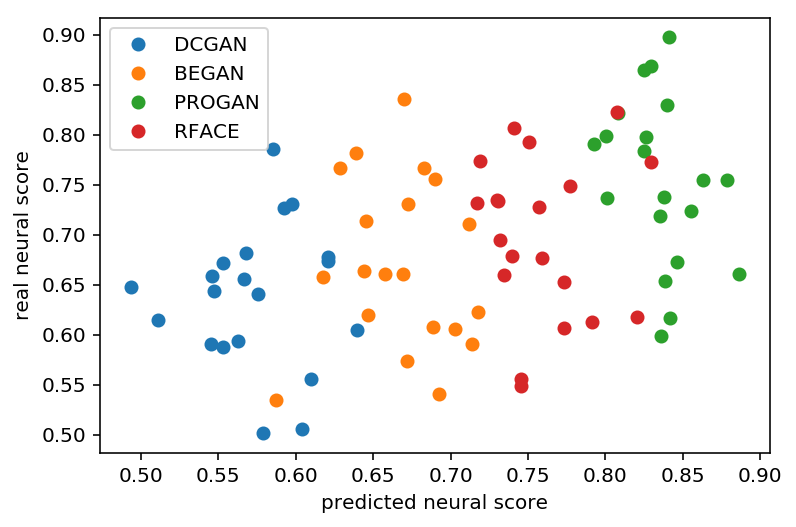

In [7]:
a = np.array(nr_loss_cat_test_loop).reshape(20, -1)
b = np.array(nr_loss_cat_true_loop).reshape(20, -1)
for i, cat in enumerate(T_IDs):
    plt.plot(a[:,i], b[:,i], 'o')
plt.xlabel('predicted neural score')
plt.ylabel('real neural score')
plt.legend(T_IDs)

In [6]:
# feed single trial P300 amplitude to loss 2
epochs = 20
loss_nr_test_loop = []
nr_loss_cat_test_loop = []
nr_loss_cat_true_loop = []
nr_loss_cat_test_loop_ = []
nr_loss_single = []



for i in trange(20):
    x_train, x_test, y_train, y_test = model_selection.train_test_split(im_ndarrays_subs, Y, 
                                                                        test_size=0.3, random_state=i)
    label_train = y_train[:, 251:252]
    label_test = y_test[:, 251:252]
    nr_train = y_train[:, 250:251]
    nr_test = y_test[:, 250:251]
    eeg_train = y_train[:, 0:250]
    eeg_test = y_test[:, 0:250]

    batch_idx = int(nr_train.shape[0]/batch_size)



    p3_dcgan_train = np.mean(eeg_train[label_train[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_began_train = np.mean(eeg_train[label_train[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_progan_train = np.mean(eeg_train[label_train[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_rface_train = np.mean(eeg_train[label_train[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)

    p3_dcgan_test = np.mean(eeg_test[label_test[:,0]==1], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_began_test = np.mean(eeg_test[label_test[:,0]==2], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_progan_test = np.mean(eeg_test[label_test[:,0]==3], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)
    p3_rface_test = np.mean(eeg_test[label_test[:,0]==4], axis=0, keepdims=True) - np.mean(epoch_array_s_subs, axis=0, keepdims=True)


    p3_source_train = prepare_p3_source(p3_dcgan_train, p3_began_train, p3_progan_train, p3_rface_train, label_train)
    p3_source_test = prepare_p3_source(p3_dcgan_test, p3_began_test, p3_progan_test, p3_rface_test, label_test)


    init = tf.global_variables_initializer()
    sess.run(init)    


    for epoch in range(epochs):
        for idx in range(batch_idx):
            x_batch = x_train[idx*batch_size:(idx+1)*batch_size]
            nr_batch = nr_train[idx*batch_size:(idx+1)*batch_size]
            _, loss_ = sess.run([optimizer_nr, loss_nr], 
                                feed_dict={'ExpandDims:0': x_batch, 
                                          y_nr_tensor: nr_batch})
            _, loss_ = sess.run([optimizer_nr, loss_nr], 
                                feed_dict={'input:0': x_batch, 
                                y_nr_tensor: nr_batch})
        
        
        
    T_IDs = ['DCGAN', 'BEGAN', 'PROGAN', 'RFACE']
    # testing model for neural score for each independent cat
    nr_pred_test = np.empty([0,1])
    nr_loss_cat_test = []
    for cat_i, cat in enumerate(T_IDs):
        x_test_cat = x_test[label_test[:, 0] == cat_i+1]
        nr_pred_ = []
        for x_batch in x_test_cat:
            nr_pred_.append(sess.run(nr_pred, feed_dict={'ExpandDims:0': np.expand_dims(x_batch, axis=0)})[0,0])
#             nr_pred_.append(sess.run(nr_pred, feed_dict={'input:0': np.expand_dims(x_batch, axis=0)})[0,0])
        nr_loss_cat_test.append(abs(np.mean(nr_pred_) - nr_test[label_test[:,0]==cat_i+1].mean()) )
        nr_loss_cat_test_loop.append(nr_test[label_test[:,0]==cat_i+1].mean())
        nr_loss_cat_true_loop.append(np.mean(nr_pred_))
    
    nr_loss_cat_test_loop_.append(np.sum(nr_loss_cat_test))
    
print('mean:', np.mean(nr_loss_cat_test_loop_), 'std:', np.std(nr_loss_cat_test_loop_))


100%|██████████| 20/20 [2:14:42<00:00, 405.25s/it]  

mean: 0.34368085973656615 std: 0.14937015701812814


In [4]:
saver = tf.train.Saver()
saver.save(sess, 
"/home/zhengwei/notebooks/GAN/evaluate_gan/model_nr_experiment_cross_subject/model_single_trial/M_no_EEG/model.ckpt")

FailedPreconditionError: Attempting to use uninitialized value w1
	 [[Node: w1/_4 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_w1", _device="/job:localhost/replica:0/task:0/device:GPU:0"](w1)]]
	 [[Node: beta1_power/_1 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5_beta1_power", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_arg_save/Const_0_0, ^save/SaveV2/tensor_names, ^save/SaveV2/shape_and_slices)]]